# Praktikum: Session 3

[Video](https://mstream.hm.edu/paella/ui/watch.html?id=d5999ff5-2900-452f-bc19-ee559b4df048)

In dieser Session sollen Aspekte der Cross-Validation betrachtet werden. Diese soll dafür verwendet werden, optimale Werte für Hyperparameter zu bestimmen.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Generiere und visualisiere Daten:

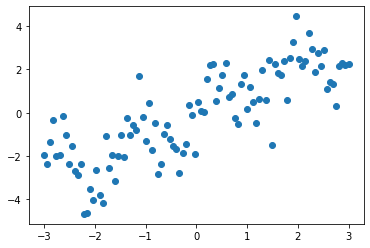

In [ ]:
# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

plt.scatter(X,y)

Wir wollen anhand dieser Daten ein Modell trainieren, dass aus dem x-Input den entsprechenden y-Output generieren kann.
Konkret wollen wir ein *k*-Nearest-Neighbors-Modell trainieren. Hierfür wollen wir im ersten Schritt untersuchen, wie sich die Wahl des Hyperparameters *k* auf die Genauigkeit auswirkt.

- Importieren Sie die passende Modellklasse aus ``sklearn.neighbors``. Es gibt dort u.a. ``KNeighborsClassifier`` und ``KNeighborsRegressor``; welchen brauchen Sie?
- Die Abhängigkeit vom Hyperparameter wollen wir in Form einer Validierungskurve darstellen (d.h. wir wollen die Genauigkeit gegen den Hyperparameter plotten). Dafür ist die Funktion ``validation_curve`` nützlich. Diese finden Sie in ``sklearn.model_selection``.
- Dort finden Sie auch die Funktion ``KFold`` (genauer ist es eine Klasse), welche wir verwenden wollen, um mehr Kontrolle über die Generierung der Folds bei der Cross-Validation (wo kommt die nochmal vor?) zu erhalten. Das funktioniert durch ``cv = KFold(n_splits=2)``. Dadurch ist ``cv`` nun ein *Cross-Validator*, also ein Objekt, das z.B. von ``validation_curve`` verwendet werden kann, und über das wir genauere Kontrolle haben.
- Wir wollen folgende Anzahlen an Nachbarn (d.h. Werte für *k*) verwenden: ``n_neighbors = [1, 3, 5, 10, 20, 30, 50]``

Verwenden Sie die Funktion ``validation_curve``, um die Trainings- bzw. Testscores für die o.g. Anzahl an berücksichtigten Nachbarn zu generieren. Speichern Sie diese in den Variablen ``train_scores`` bzw. ``test_scores``.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import validation_curve, KFold
cv = KFold(n_splits=2)
n_neighbors = [1, 3, 5, 10, 20, 30, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)

Folgende Zelle plottet diese beiden Scores gegen die Anzahl der Nachbarn.
- Warum wird jeweils ``.mean`` verwendet?

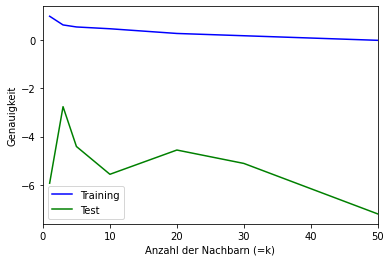

In [ ]:
plt.plot(n_neighbors, train_scores.mean(axis=1), 'b', label="Training")
plt.plot(n_neighbors, test_scores.mean(axis=1), 'g', label="Test")
plt.ylabel('Genauigkeit')
plt.xlabel('Anzahl der Nachbarn (=k)')
plt.xlim([0, 50])
plt.legend(loc="best");

In [ ]:
KNeighborsRegressor?

## Prinzipielles Problem: Schlechte Score

Was ist die "Genauigkeit" hier? Die Dokumentation von ``sklearn.neighbors.KNeighborsRegressor`` sagt dazu folgendes:
"(Score) returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0."

Warum ist die Genauigkeit des Modells **so** schlecht?

Die Antwort auf diese Frage liegt in der Art und Weise, wie die Daten in Trainings- und Validierungsdaten aufgeteilt wurden. Dies wollen wir daher näher untersuchen. Die im Folgenden definierte Funktion ``plot_cv`` stellt die Aufteilung der 100 Datenpunkte in Trainings- und Validierungsdaten in jedem einzelnen Fold grafisch dar.

In [ ]:
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')

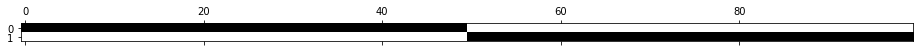

In [ ]:
plot_cv(cv, X,y)

Machen Sie sich mit dieser Art der Visualisierung vertraut, indem Sie anstatt der oben gewählten zwei Folds fünf Folds verwenden und die Aufteilung plotten.

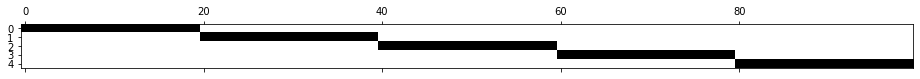

In [ ]:
cv = KFold(n_splits=5)
plot_cv(cv, X,y)

Wir verwenden nun wieder die Aufteilung in zwei Folds. Es ist deutlich zu sehen, wie die Aufteilung von statten geht: Die Daten werden in der Mitte geteilt. Das sorgt dafür, dass das Modell auf den ersten 50 Datenpunkten (unten rot dargestellt) trainiert wird, validiert wird es aber auf den letzten 50 Datenpunkten (unten blau dargestellt).

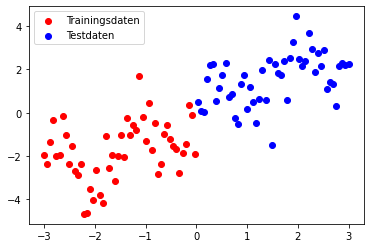

In [ ]:
cv = KFold(n_splits=2)
for train_index, test_index in cv.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

plt.scatter(X_train, y_train, c='r', label='Trainingsdaten');
plt.scatter(X_test, y_test, c='b', label='Testdaten');
plt.legend(loc='best');

- Beschreiben Sie die Probleme, die daraus entstehen könnten.
- Verifizieren Sie, dass dieses Problem in der Tat entsteht. Trainieren Sie dafür ein Modell (z.B. mit ``n_neighbors=2``) auf den gerade erzeugten Trainingsdaten und wenden Sie dieses auf die Testdaten an.
- Plotten Sie das Ergebnis.

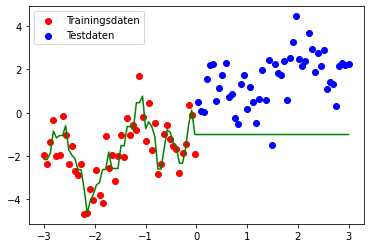

In [ ]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(X_train,y_train)
y_model = model.predict(X)

plt.scatter(X_train, y_train, c='r', label='Trainingsdaten');
plt.scatter(X_test, y_test, c='b', label='Testdaten');
plt.legend(loc='best');
plt.plot(X, y_model, c='g');

Wie könnte man dieses Problem lösen?
- Verwenden Sie eine Cross-Validation-Klasse, die dieses Problem umgeht. *Hinweis: Hierfür ist es lediglich notwendig, ``KFold`` ein weiteres Argument mitzugeben.*
- Erstellen Sie den "Schwarz-Weiß-Plot" und den "Rot-Blau-Plot" für die neue Situation.

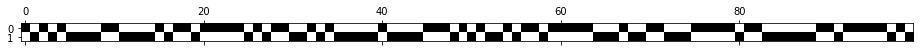

In [ ]:
cv = KFold(shuffle=True, n_splits=2)
plot_cv(cv, X,y)

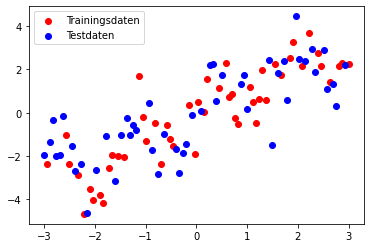

In [ ]:
cv = KFold(shuffle=True, n_splits=2)
for train_index, test_index in cv.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

plt.scatter(X_train, y_train, c='r', label='Trainingsdaten');
plt.scatter(X_test, y_test, c='b', label='Testdaten');
plt.legend(loc='best');

Trainieren Sie erneut ein Modell auf den (nun zufällig gewählten) Trainingsdaten und wenden Sie es auf die Testdaten an. Stellen Sie auch das wieder grafisch dar.



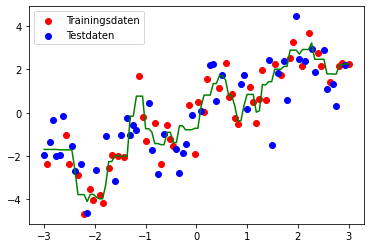

In [ ]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(X_train,y_train)
y_model = model.predict(X)

plt.scatter(X_train, y_train, c='r', label='Trainingsdaten');
plt.scatter(X_test, y_test, c='b', label='Testdaten');
plt.legend(loc='best');
plt.plot(X,y_model, c='g');

## Zurück zur Wahl des Hyperparameters *k*:

Verwenden Sie nun eine sinnvollere Aufteilung in Trainings- und Testdaten (d.h. mit Durchmischen) und ermitteln Sie nochmal (analog zu oben) die Trainings- bzw. Testscores für *k* = 1, 3, 5, 10, 20, 30, 50. Stellen Sie dies als Validierungskurve dar.

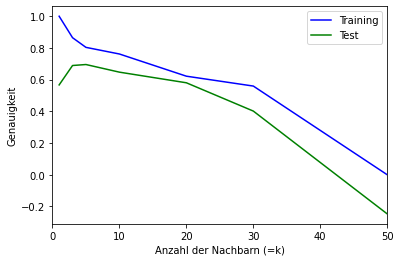

In [ ]:
cv = KFold(shuffle=True, n_splits=2)
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_scores.mean(axis=1), 'b', label="Training")
plt.plot(n_neighbors, test_scores.mean(axis=1), 'g', label="Test")
plt.ylabel('Genauigkeit')
plt.xlabel('Anzahl der Nachbarn (=k)')
plt.xlim([0, 50])
plt.legend(loc="best");

Vieeeel besser!
- Welchen Wert für *k* würden Sie als den besten wählen?
- Erkunden Sie, wie sich das Modell durch den Wert von *k* verändert. Trainieren Sie dazu ein Modell auf dem gesamten Datensatz. Visualisieren Sie es, indem Sie den vorhergesagten Wert für 200 äquidistant verteilte Punkte plotten.

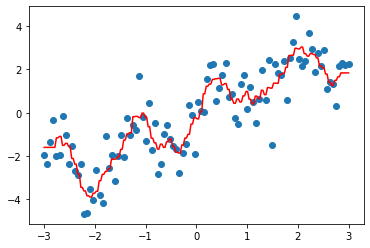

In [ ]:
x_lin = np.linspace(-3,3,200)
X_lin = x_lin[:, np.newaxis]
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X,y)
y_model = model.predict(X_lin)

plt.scatter(X,y)
plt.plot(X_lin,y_model, c='r')

## Andere Modellklasse mit mehreren Hyperparamtern: SVM

Wir verwenden nun eine andere Klasse von Modellen, um das vorliegende Regressionsproblem zu lösen, die sog. Support Vector Regression (SVR).

Hier können insbesondere die Hyperparameter ``C`` und ``gamma`` zu wählen. Es gilt hier also, eine optimale *Kombination* zweier Parameter zu finden. Dazu wollen wir alle Kombinationen der Werte C=[0.001, 0.01, 0.1, 1, 10] und gamma=[0.001, 0.01, 0.1, 1] durchprobieren.
Da solche Aufgaben häufig vorkommen, gibt es hierfür eine Klasse in ``Scikit Learn``: ``GridSearchCV``. Dieser Klasse wird übergeben:

- welche Parameter durchprobiert werden sollen
- welches Modell trainiert werden soll

``GridSearchCV`` ist ein *Meta-Estimator*. Als solcher nimmt er einen regulären Estimator (wie z.B. SVR oder KNearestNeighbors) und generiert einen neuen Estimator, welcher sich genauso verhält (in diesem Fall wie ein Regressor). Folglich enthält Methoden wie ``fit`` und ``predict``.

Im Folgenden legen wir in ``param_grid`` fest, welche Werte für ``C`` bzw. ``gamma`` probiert werden sollen.

Außerdem legen wir den Meta-Estimator ``grid`` an; dieser basiert auf einem SVR-Modell, verwendet zur Suche das gerade angelegte ``param_grid``, die Cross-Validation wird gemäß ``cv`` durchgeführt. Der Parameter ``verbose`` gibt das Detaillevel der Rückmeldung an (verfügbar in vielen Methoden). 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3)

Fitten Sie den Meta-Estimator an die Daten.

In [ ]:
grid.fit(X, y)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.053, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.078, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ................ C=0.001, gamma=0.01, score=-0.052, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ................ C=0.001, gamma=0.01, score=-0.077, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ................. C=0.001, gamma=0.1, score=-0.043, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ................. C=0.001, gamma=0.1, score=-0.072, total=   0.0s
[CV] C=0.001, gamma=1 ................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

Dieses Fitten mach folgendes:
- Cross-Validation, um anhand dessen den die optimale Parameterkonstellation zu ermitteln (d.h. die beste der getesteten)
- Mit dieser optimalen Kombination wird dann ein Modell auf den kompletten Daten gefittet (ohne Cross-Validation).

Auf dieses Modell haben wir dann Zugriff.
- ``grid.predict`` kann dieses optimale Modell auf (neue) Daten anwenden.
- ``grid.best_params_`` enthält die besten Parameterwerte.
- ``grid.best_score_`` enthält die beste erzielte Score.

Welche Parameterkombination ist im vorliegenden Fall die beste?

In [ ]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


In ``grid_cv_results_`` sind noch wesentlich mehr Informationen enthalten. Diese können gut als DataFrame dargestellt werden:

In [ ]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003582,0.002652,0.000976,2.300739e-05,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.053435,-0.078170,-0.065802,0.012368,20
1,0.000852,0.000058,0.001039,1.100302e-04,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.051524,-0.076917,-0.064221,0.012696,19
2,0.001132,0.000020,0.000802,8.666515e-05,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",-0.042531,-0.071706,-0.057118,0.014588,16
3,0.000655,0.000008,0.000769,3.111362e-05,0.001,1,"{'C': 0.001, 'gamma': 1}",-0.042995,-0.072824,-0.057909,0.014914,17
4,0.000694,0.000023,0.000576,1.513958e-05,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.051348,-0.076782,-0.064065,0.012717,18
5,0.000696,0.000003,0.000533,2.980232e-06,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",-0.032424,-0.063105,-0.047765,0.015341,15
6,0.000698,0.000032,0.000614,5.328655e-05,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.052435,0.007175,0.029805,0.022630,12
7,0.000803,0.000113,0.000551,2.300739e-05,0.01,1,"{'C': 0.01, 'gamma': 1}",0.047392,-0.006818,0.020287,0.027105,13
8,0.000641,0.000020,0.000544,1.883507e-05,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",-0.030689,-0.061219,-0.045954,0.015265,14
9,0.000676,0.000019,0.000543,1.358986e-05,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.141231,0.077471,0.109351,0.031880,11


Visualisieren Sie das Modell, indem Sie den vorhergesagten Wert für 200 äquidistant verteilte Punkte plotten.

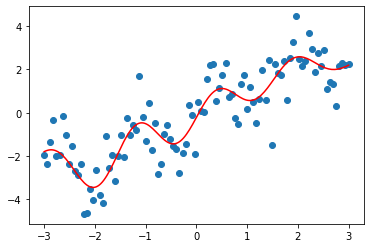

In [ ]:
x_lin = np.linspace(-3,3,200)
X_lin = x_lin[:, np.newaxis]
y_model = grid.predict(X_lin)

plt.scatter(X,y)
plt.plot(X_lin,y_model, c='r')